In [2]:
options(tidyverse.quiet = TRUE)
library(tidyverse)

source("../R/priors.R")
source("../R/functions.R")

## Comparison of required sample sizes by power-constraint criterion

In [179]:
prior            <- Normal(0.3, 0.2, -0.2, 0.7)
# one sided maximal type one error rate
alpha            <- 0.025
# minimal power/expected power/probability of success is 1 - beta
beta             <- 0.2
# upper boundary of the null hypothesis for the location parameter 
# H0: theta <= theta_null
theta_null       <- 0.0
# minimal clinically important difference (MCID)
theta_mcid       <- 0.1

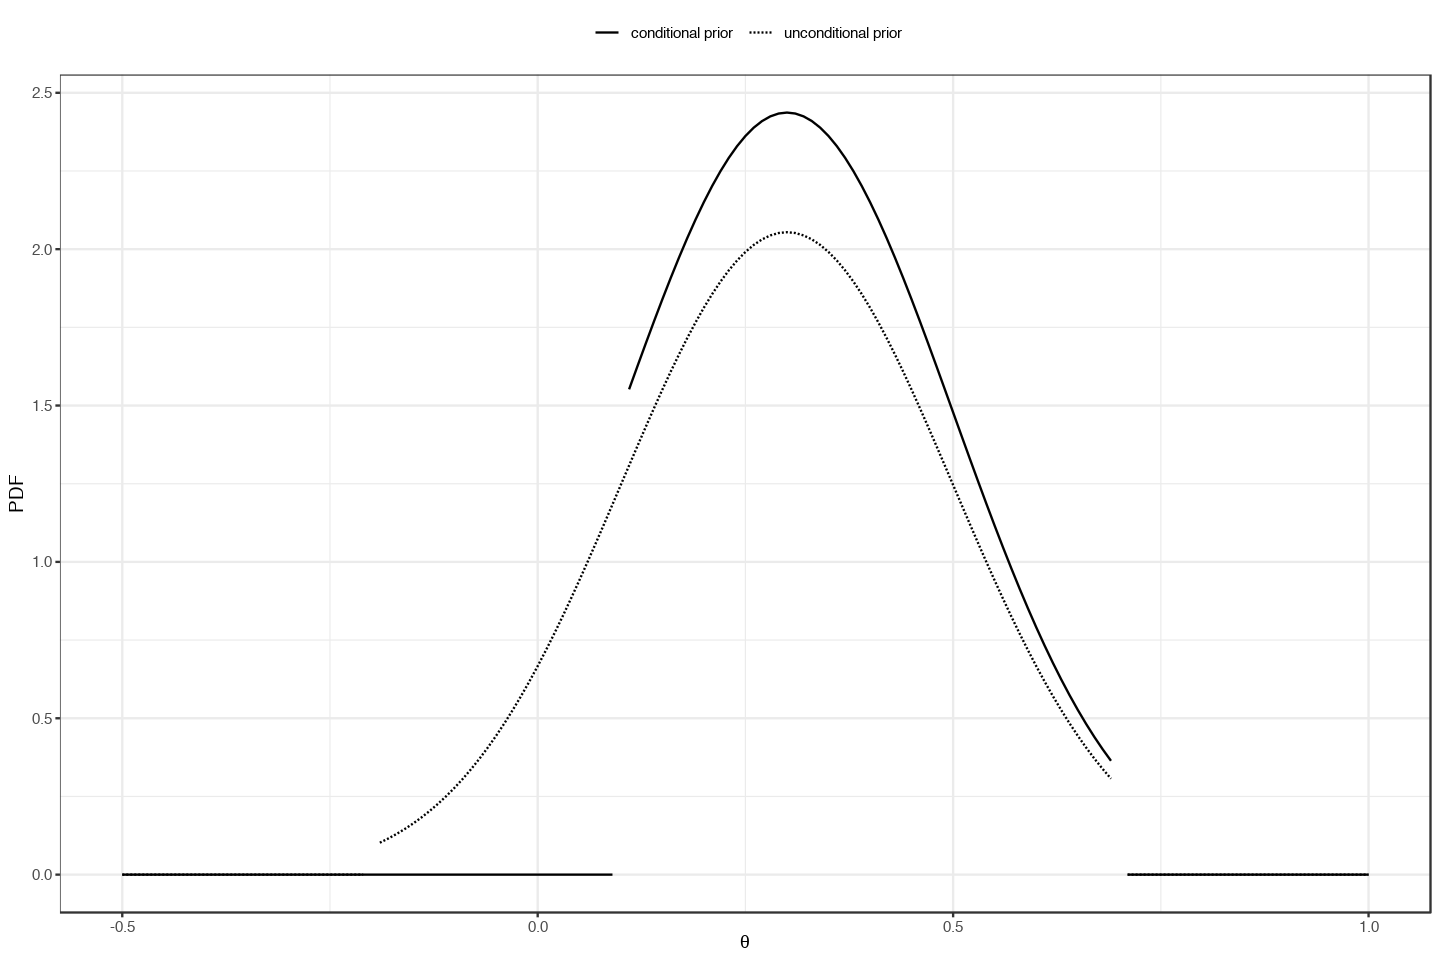

In [183]:
plt_prior <- tibble(
    theta = seq(-0.5, 1.0, .01),
    `unconditional prior` = pdf(prior, theta) %>% 
        {ifelse(theta == .7 | theta == prior$lower, NA_real_, .)},
    `conditional prior`   = pdf(condition(prior, lo = theta_mcid), theta) %>% 
        {ifelse(theta == .7 | (theta == theta[which.min(abs(theta_mcid - theta))]), NA_real_, .)}
) %>%
pivot_longer(-theta, names_to = "type", values_to = "PDF") %>%
ggplot() +
aes(theta, PDF, linetype = type) +
geom_line() +
scale_linetype_discrete("") +
scale_x_continuous(expression(theta)) +
theme_bw() +
theme(
    legend.position = "top"
)

plt_prior

In [184]:
tbl_samplesizes <- tibble(
    "MCID" = get_n(theta_null, theta_mcid),
    "EP"   = get_n_ep(theta_null, prior, mrv = theta_mcid, pwr = 1 - beta, alpha = alpha),
    "quantile, 0.9"   = get_n_quantile(theta_null, prior, .9, mrv = theta_mcid, pwr = 1 - beta, alpha = alpha),
    "quantile, 0.5"   = get_n_quantile(theta_null, prior, .5, mrv = theta_mcid, pwr = 1 - beta, alpha = alpha)
) %>%
pivot_longer(everything(), names_to = "type", values_to = "n")

tbl_samplesizes

type,n
<chr>,<dbl>
MCID,785
EP,162
"quantile, 0.9",311
"quantile, 0.5",71


In [185]:
prior
quantile(condition(prior, lo = theta_mcid), 1 - 0.5)
quantile(condition(prior, lo = theta_mcid), 1 - 0.9)

$mu
[1] 0.3

$tau
[1] 0.2

$lower
[1] -0.2

$upper
[1] 0.7

$normalizing_constant
[1] 0.9710402

attr(,"class")
[1] "Normal" "list"

[1] 0.3342328

[1] 0.1590704

In [155]:
tbl <- full_join(
        tbl_samplesizes,
        expand_grid(
            theta = seq(-0.2, 0.7, by = 0.01),
            n = tbl_samplesizes$n
        ),
        by = "n"
    ) %>%
    mutate(
        power = map2_dbl(theta, n, ~power(..1, ..2, qnorm(1 - alpha))),
        name = sprintf("%s (n = %i)", type, n)
    )

In [159]:
plt_powr_curves <- tbl %>%
    ggplot() +
    aes(theta, power, color = name) + 
    geom_line() + 
    scale_color_discrete("") +
    scale_x_continuous(expression(theta), breaks = seq(-1, 1, .1)) +
    scale_y_continuous(breaks = seq(0, 1, .1), expand = c(0, 0)) +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank(),
        legend.position = "top"
    )

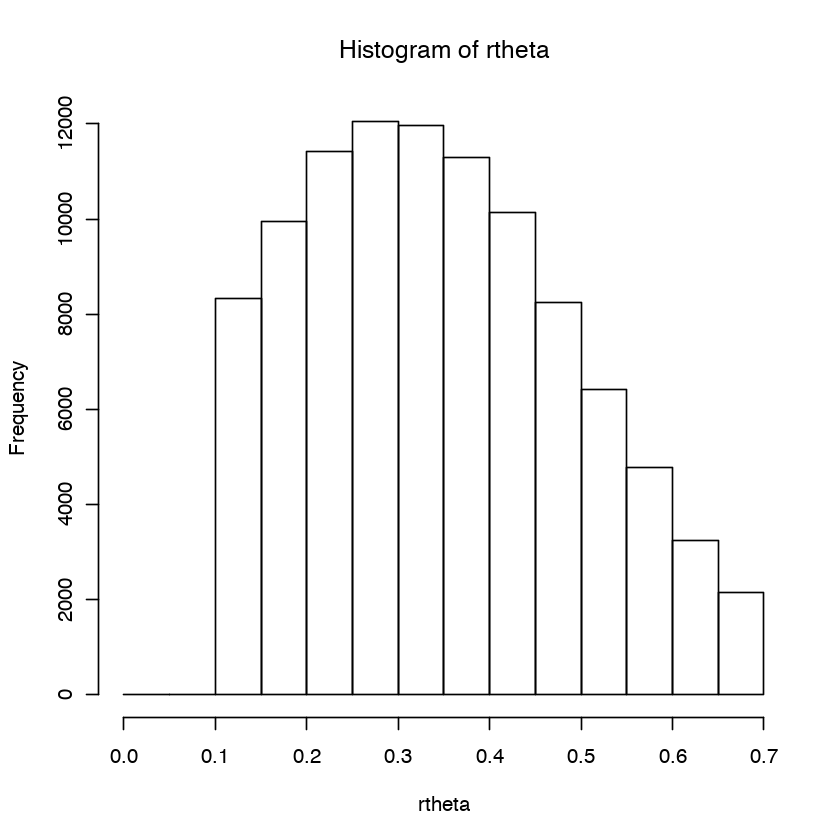

In [143]:
n <- 1e5
rtheta <- numeric(n)
cprior <- condition(prior, lo = theta_mcid)
i <- 1
while (i < n) {
    sample <- rnorm(1, mean = cprior$mu, sd = cprior$tau)
    if (between(sample, cprior$lower, cprior$upper)) {
        rtheta[i] <- sample
        i <- i + 1
    }
}
hist(rtheta)

In [156]:
plt_power_cdf <- full_join(
        tbl_samplesizes,
        expand_grid(
            rtheta = rtheta,
            n = tbl_samplesizes$n
        ),
        by = "n"
    ) %>% 
    mutate(
        rpower = map2_dbl(rtheta, n, ~power(..1, ..2, qnorm(1 - alpha))),
        name = sprintf("%s (n = %i)", type, n)
    ) %>%
    select(name, rpower) %>%
    group_by(name) %>%
    nest() %>%
    transmute(
        ecdf = map(data, ~tibble(
            power = seq(0, 1, .01),
            CDF   = ecdf(.$rpower)(power)
        ))
    ) %>%
    unnest(ecdf) %>%
    ggplot(aes(power, CDF, color = name)) + 
    geom_line() +
    scale_color_discrete("") +
    scale_x_continuous(breaks = seq(0, 1, .1)) +
    scale_y_continuous(breaks = seq(0, 1, .1)) +
    coord_cartesian(expand = FALSE) +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank(),
        legend.position = "top"
    )

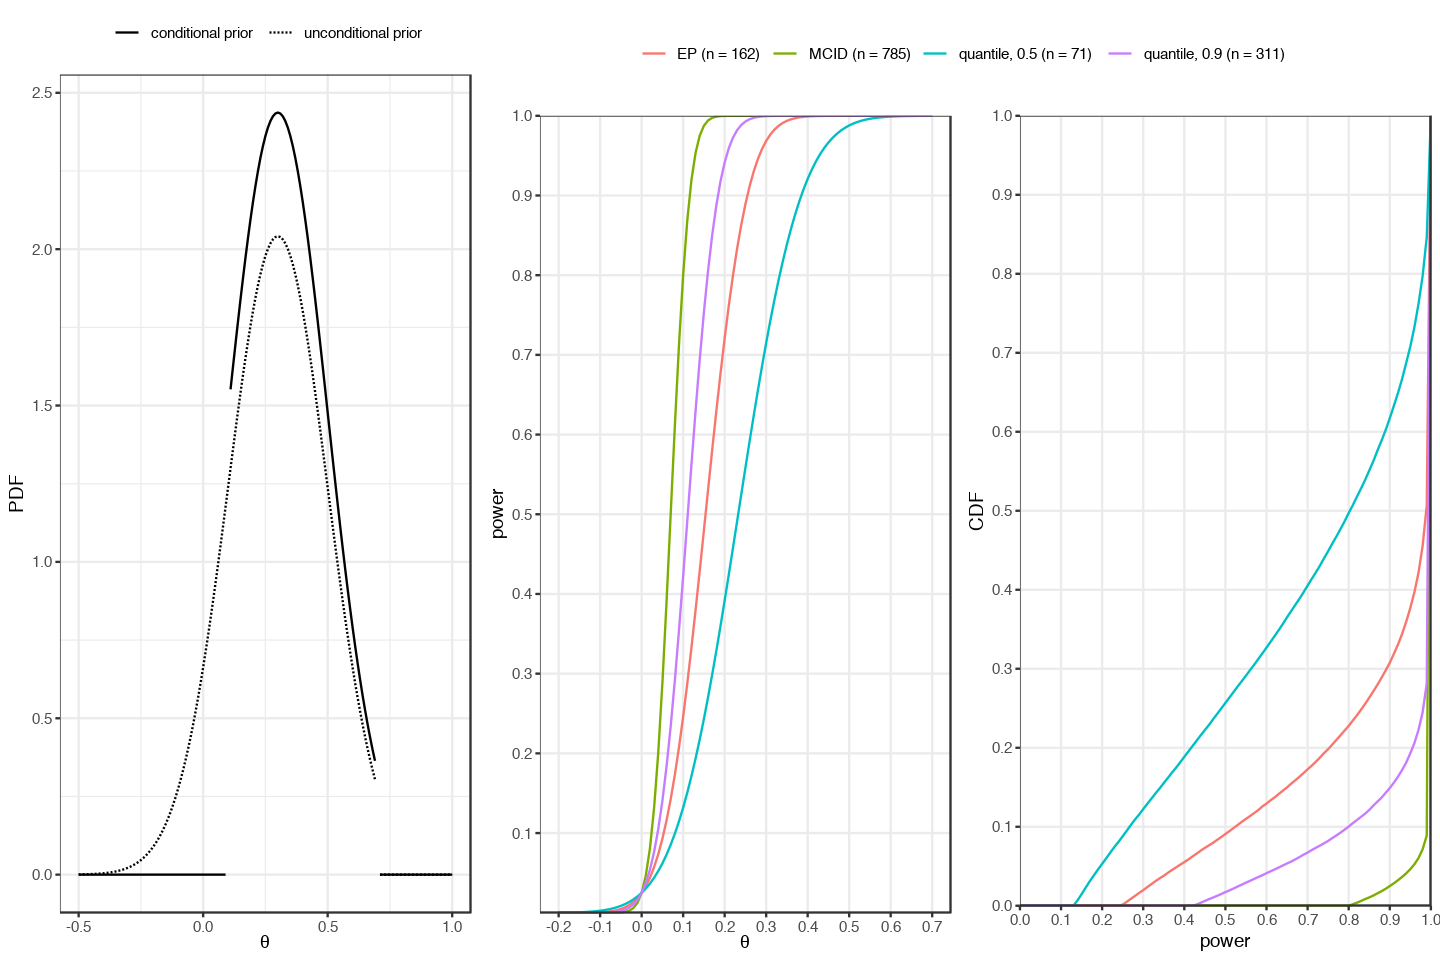

In [175]:
legend <- cowplot::get_legend(plt_powr_curves)
cowplot::plot_grid(plt_prior, 
    cowplot::plot_grid(
        legend,
        cowplot::plot_grid(
            plt_powr_curves + theme(legend.position = "none"), 
            plt_power_cdf + theme(legend.position = "none"),
            nrow = 1
        ), 
        rel_heights = c(1, 8),
        ncol = 1
    ),
    rel_widths = c(1, 2),
    nrow = 1
)
                   
ggsave('../latex/figures/example.pdf', width = 9, height = 5)